# modelos

> Implementación de diferentes tipos de modelos espacialesa y espaciales para estudios criminológicos.

In [ ]:
#| default_exp modelos

In [1]:
#| include: false
from nbdev.showdoc import *

In [2]:
#| export
import warnings
from functools import reduce
from itertools import chain
import math
import random
import string
import copy
import os
from fastcore.basics import patch
import numpy as np
import pandas as pd
import geopandas as gpd
from libpysal.weights import Queen, lag_spatial
from esda.moran import Moran
from splot.esda import moran_scatterplot
import statsmodels.formula.api as smf 
import statsmodels.api as sm
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from criminologia_cdmx.etl import *
from criminologia_cdmx.covariables import *

In [3]:
#| hide
%load_ext autoreload
%autoreload 2

## variable_dependiente

In [4]:
#| export
def variable_dependiente(datos:gpd.GeoDataFrame, # carpetas/victimas con ids espaciales y categorías de usuario
                         columna_y:str, # Nombre de la columna en donde vienen los incidentes de valor_y
                         valores_y:str, # delitos o categorías a utilizar como Y
                         fecha_inicio:str, # fecha inicial para agregar delitos "d-m-Y" 
                         fecha_fin:str, # fecha final para agregar delitos "d-m-Y"
                         agregacion:str='colonias', # colonias/cuadrantes/manzanas
                         nombre_y:str=None # Nombre para la columna con la variable dependiente
                         )->pd.DataFrame:
    """ Regresa un DataFrame con la variable independicente agregada entre fecha_inicio y fecha_fin
        en las unidades requeridas."""
    fecha_inicio = pd.to_datetime(fecha_inicio, dayfirst=True)
    fecha_fin = pd.to_datetime(fecha_fin, dayfirst=True)
    datos = datos.loc[datos['fecha_hechos'].between(fecha_inicio, fecha_fin)]
    datos = datos.loc[datos[columna_y].isin(valores_y)]
    if agregacion == 'colonias':
        columna_agrega = 'colonia_cve'
        layer = 'colonias'
    elif agregacion == 'cuadrantes':
        columna_agrega = 'cuadrante_id'
        layer = 'cuadrantes'
    elif agregacion == 'manzanas':
        try:
            assert 'manzana_cvegeo' in datos.columns
        except AssertionError:
            print("Para usar la agregación por manzanas primero \
                  debes agregar el identificador correspondiente")
            raise
        columna_agrega = 'manzana_cvegeo'
    else:
        raise ValueError("unidades debe ser 'colonias' o 'cuadrantes'")
    datos = datos.groupby(columna_agrega).size()
    if nombre_y is not None:
        datos.name = nombre_y
    else:
        datos.name = " ".join(valores_y)
    if agregacion in ('colonias', 'cuadrantes'):
        pth_capas = os.path.abspath(os.path.join(DATA_PATH, 'criminologia_capas.gpkg'))
        unidades = gpd.read_file(pth_capas, layer=layer)
    else:
        pth_manzanas = descarga_manzanas()
        unidades = (gpd
                    .read_file(pth_manzanas, layer="manzanas")
                    .rename({"CVEGEO": columna_agrega}, axis=1))
        
    datos = unidades[[columna_agrega]].merge(datos, on=columna_agrega, how='left').fillna(0)
    return datos   

In [7]:
carpetas = get_carpetas_from_api(100000)
carpetas = agrega_ids_espaciales(carpetas)
fecha_inicio = carpetas.fecha_hechos.min().strftime("%d-%m.%Y")
fecha_fin = carpetas.fecha_hechos.max().strftime("%d-%m.%Y")
# Prueba con un delito
delito = ['ROBO A CASA HABITACION SIN VIOLENCIA']
Y = variable_dependiente(carpetas, 'delito', delito, fecha_inicio, fecha_fin, 
                           agregacion='cuadrantes')
assert delito[0] in Y.columns
assert 'cuadrante_id' in Y.columns
Y = variable_dependiente(carpetas, 'delito', delito, fecha_inicio, fecha_fin)
assert delito[0] in Y.columns
assert 'colonia_cve' in Y.columns
Y = variable_dependiente(carpetas, 'delito', delito, fecha_inicio, fecha_fin, 
                         agregacion='manzanas')
assert delito[0] in Y.columns
assert 'manzana_cvegeo' in Y.columns
# Prueba con dos delitos y nombre de columna
delitos = ['ROBO A CASA HABITACION SIN VIOLENCIA', 'ROBO A CASA HABITACION CON VIOLENCIA']
nombre_y = "Robo a Casa habitación (CV/SV)"
Y = variable_dependiente(carpetas, 'delito', delitos, fecha_inicio, fecha_fin, 
                           agregacion='cuadrantes', nombre_y=nombre_y)
assert nombre_y in Y.columns
Y = variable_dependiente(carpetas, 'delito', delitos, fecha_inicio, fecha_fin, 
                           agregacion='manzanas', nombre_y=nombre_y)
assert nombre_y in Y.columns
Y = variable_dependiente(carpetas, 'delito', delitos, fecha_inicio, fecha_fin, 
                           nombre_y=nombre_y)
assert nombre_y in Y.columns

El archivo ya está descargado.
El archivo ya está descargado.
El archivo ya está descargado.


## CapaDeAnalisis

La clase `CapadeAnalisis` encapsula los datos y la funcionalidad para correr diferentes tipos de análisis criminológico.

In [50]:
#| export
class CapaDeAnalisis(object):
    """ Clase para contener variable objetivo y covariables."""
    
    def __init__(self,
                 Y:pd.DataFrame, # la variable dependiente.
                 covariables: pd.DataFrame, # las variables independientes
                 agregacion:str='colonias' # colonias/cuadrantes
                 ):
        self.Y:pd.DataFrame = Y # la variable dependiente.
        self.campo_id:str = self.__get_campo_id(agregacion) # el nombre del campo común en X y Y para unirlos.
        self.Y_nombre:str = Y.columns[-1] # Nombre de la columna con el delito a modelar. Se asume que la última columna tiene la variable de interés
        self.X:pd.DataFrame = covariables # las variables independientes
        self.X_nombres:list = [x for x in covariables.columns if x != self.campo_id] # Lista de los nombres de columnas de las covariables.
        self.agregacion:str = agregacion # colonias/cuadrantes
        self.df:pd.DataFrame = self.__merge_covars() # la unión de los X con Y.
        self.geo:gpd.GeoDataFrame = self.__get_geo(agregacion) # la unión de df con las geometrias que corresponden a `agregacion`
        self.w:Queen = self.__calcula_matriz_pesos() # Matriz de vecindad para los datos válidos
        # TODO self_repr() una función que describa en texto lo que pasó (datos válidos, etc.)
        
    def __merge_covars(self):
        """Regresa la unión de X y Y."""
        # TODO: aquí hay que contar cuántos datos perdimos por valores faltantes
        df = (self.Y.merge(self.X, on=self.campo_id)
                    .replace([np.inf, -np.inf], np.nan)
                    .dropna())
        df = df.set_index(self.campo_id)
        return df
    
    def __get_campo_id(self, agregacion):
        """ Regresa la columna que une los dataframes."""
        if agregacion == 'colonias':
            campo_id = 'colonia_cve'
        elif agregacion == 'cuadrantes':
            campo_id = 'cuadrante_id'
        else:
            raise ValueError("agregacion debe ser colonias o cuadrantes.")
        return campo_id
    
    def __get_geo(self, agregacion):
        """ Regresa el GeoDataframe correspondiente a la agregación."""
        geo = gpd.read_file(DATA_PATH/'criminologia_capas.gpkg', layer=agregacion)
        geo = geo.set_index(self.campo_id)
        geo = geo.join(self.df, how='inner')
        return geo
    
    def __calcula_matriz_pesos(self):
        """Regresa la matriz de peso y actualiza geo y df para eliminar las islas."""
        # TODO: aquí hay que contar los datos perdidos por islas
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            w = Queen.from_dataframe(self.geo.reset_index(), idVariable=self.campo_id)
            if len(w.islands):
                print(f"Las observaciones con {self.campo_id} {w.islands} son islas, las vamos a eliminar")
                self.df.drop(w.islands, inplace=True)
                self.geo.drop(w.islands, inplace=True)
                w = Queen.from_dataframe(self.geo)
        return w
    

        
    # TODO: 
    # agregar/quitar variables
    # checar que exista el campo_id en las dos bases
    # quitamos unas filas, hay que llevar registro de eso
    # Implementar transformadores sobre las variables
    

In [66]:
show_doc(CapaDeAnalisis.__init__)

---

### CapaDeAnalisis.__init__

>      CapaDeAnalisis.__init__ (Y:pandas.core.frame.DataFrame,
>                               covariables:pandas.core.frame.DataFrame,
>                               agregacion:str='colonias')

Initialize self.  See help(type(self)) for accurate signature.

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| Y | DataFrame |  | la variable dependiente. |
| covariables | DataFrame |  | las variables independientes |
| agregacion | str | colonias | colonias/cuadrantes |

In [51]:
# Prepara datos
usos = get_uso_de_suelo()
usos = agrega_uso_suelo(usos, unidades='colonias')
# Crea la capa
ca = CapaDeAnalisis(Y, usos, 'colonias')
# Pruebas de consistencia
assert ca.X.equals(usos)
assert ca.Y.equals(Y)
assert ca.geo.shape[0] == ca.df.shape[0]

/home/plablo/miniconda3/envs/criminologia_cdmx/lib/python3.10/site-packages/pandas/core/internals/blocks.py:352: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


Las observaciones con colonia_cve [672, 680, 681, 851, 1125, 1277] son islas, las vamos a eliminar


### Copiar una capa

A veces va a resultar importante tener copias en lugar de modificar el objeto original.

In [52]:
#| export

@patch
def copia(self:CapaDeAnalisis):
    """Regresa una copia del objeto"""
    return copy.deepcopy(self)

In [53]:
ca_nueva = ca.copia()
assert ca == ca

### Histograma de la variable dependiente

In [54]:
#| export
@patch
def displot_Y(self:CapaDeAnalisis, 
              size:tuple=(12,6) # Tamaño de la gráfica
            )->Axes:
    """Regresa el histograma de la variable dependiente."""
    f, ax = plt.subplots(1,figsize=size)
    ax = sns.histplot(data=self.Y, x=self.Y_nombre, ax=ax)
    ax.axvline(x=self.Y[self.Y_nombre].mean(), color='red')
    ax.set_ylabel("Conteo")
    return ax


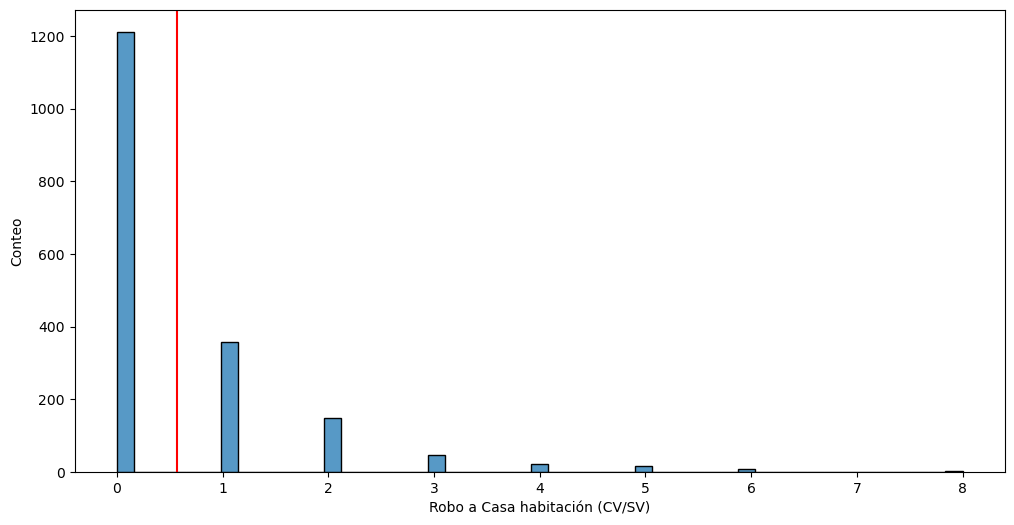

In [55]:
ax = ca.displot_Y()

### Gráfica de pares de las variables independientes

In [56]:
@patch
def pairplot_X(self:CapaDeAnalisis, 
               altura=10,# Altura de la gráfica
               ratio=1 # Aspect ratio
    )->sns.PairGrid:
    """Regresa un pairplot de las variables independientes."""
    return sns.pairplot(self.X)

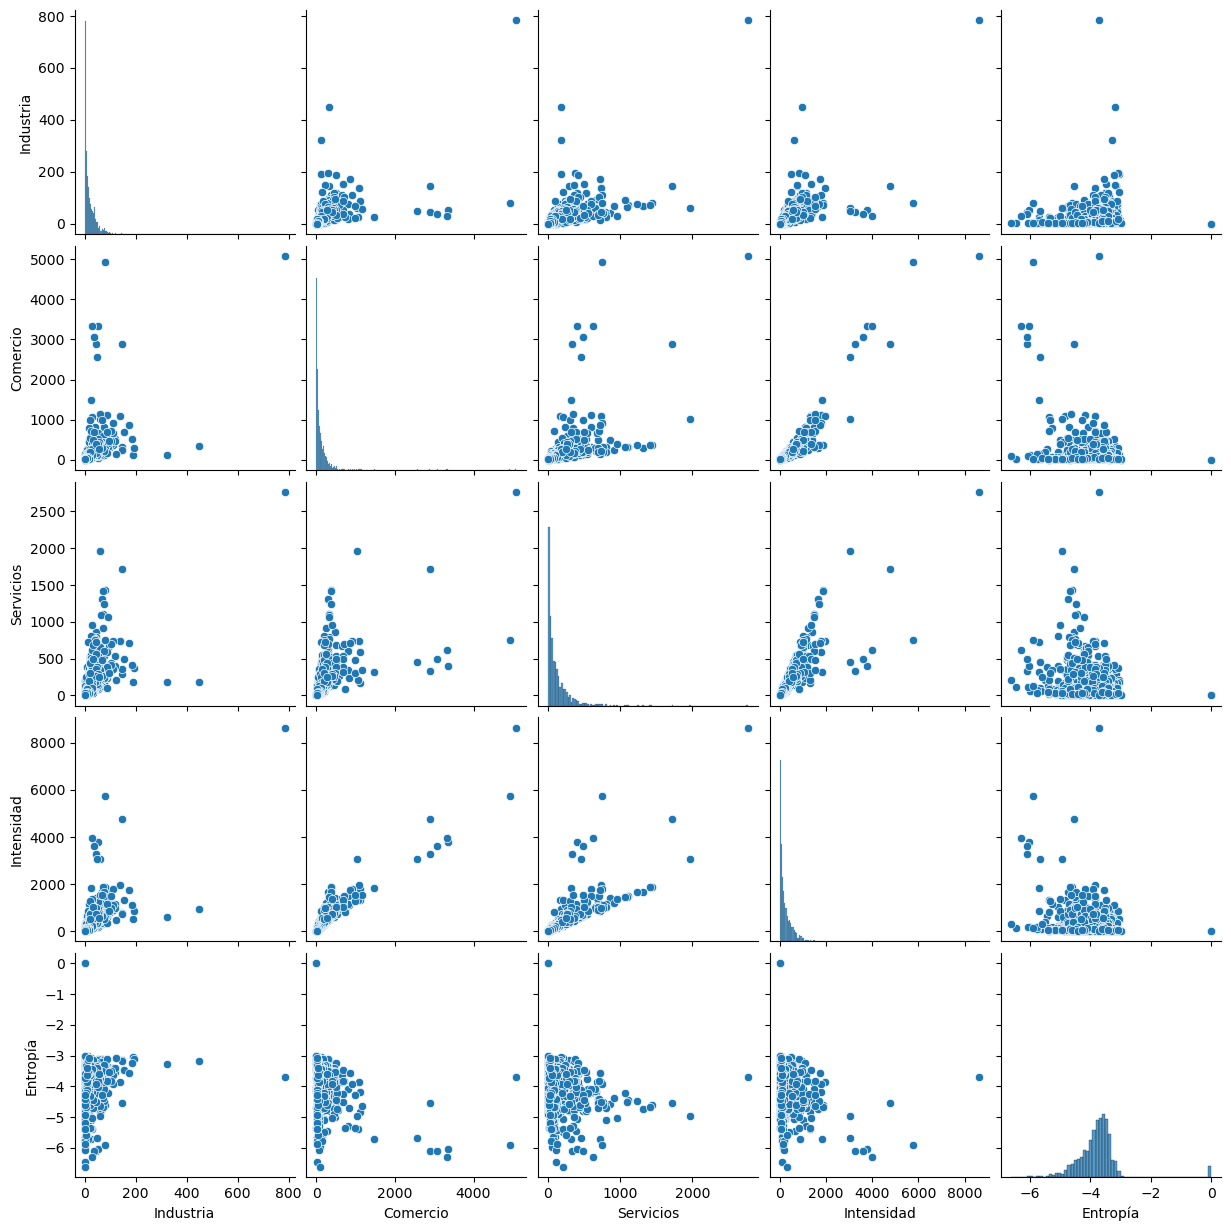

In [57]:
pg = ca.pairplot_X()

### Descripción de la variable dependiente

In [58]:
#| export
@patch
def describe_Y(self:CapaDeAnalisis)->pd.DataFrame:
    """Regresa un DataFrame con estadísticas descriptivas de la variable dependiente."""
    d = self.Y[self.Y_nombre].describe()
    v = pd.Series({"Var":self.Y[self.Y_nombre].var()})
    d = pd.concat([d,v])
    d = pd.DataFrame(d)
    d = d.reset_index()
    d.columns = ['Estadístico', '']
    d = d.set_index('Estadístico')
    orden = ['count', 'mean','Var',  'std', 'min', '25%', '50%', '75%', 'max']
    d = d.reindex(orden)
    d = d.rename({'count': 'N', 'mean': 'Media', 
                    'Var':'Varianza', 
                    'std': 'Desviación estándar',
                    'min': 'Mínimo',
                    'max': 'Máximo'})
    return d

In [59]:
ca.describe_Y()

,
Estadístico,
N,1813.000000
Media,0.566464
Varianza,1.081259
Desviación estándar,1.039836
Mínimo,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
Máximo,8.000000


### Retraso espacial

Podemos calcular el retraso espacial de las variables dependientes. El método `CapaDeAnalisis.retraso_x` agraga una columna a `CapaDeAnalisis.df` y `CapaDeAnalisis.geo` con el retraso de la variable que se quiera.

:::{.callout-note}

Por lo pronto se usa la matriz de vecindad que calculada en `__calcula_matriz_pesos`.

La nueva columna se va a nombrar `columna`_lag.

:::

In [60]:
#| export
@patch
def retraso_x(self:CapaDeAnalisis, 
             columna # Sobre qué columna de `CapaDeAnalisis.X` vamos a calcular el retraso
    ) -> CapaDeAnalisis:
    """ Agrega una columna con el retraso espacial de la variable `columna`.
    
        La nueva columna se va a nombrar `columna`_lag.
        
        **NOTA:** Por lo pronto se usa la matriz de vecindad que calculada en 
        `__calcula_matriz_pesos`.
    """
    self.w.transform = 'R'
    rezago = lag_spatial(self.w, self.df[columna])
    self.df[columna + '_lag'] = rezago
    self.X_nombres.append(columna + '_lag')
    return self

In [61]:
ca = ca.retraso_x('Intensidad')
ca.df

,Robo a Casa habitación (CV/SV),Industria,Comercio,Servicios,Intensidad,Entropía,Intensidad_lag
colonia_cve,,,,,,,
1,1.0,11,61,49,121,-3.628926,241.000000
2,0.0,12,41,55,108,-3.495848,212.800000
3,0.0,10,52,88,150,-3.914702,265.000000
4,1.0,24,156,93,273,-3.702768,147.428571
5,2.0,27,508,446,981,-4.586768,133.777778
...,...,...,...,...,...,...,...
1807,1.0,2,13,10,25,-3.728291,65.333333
1809,0.0,3,23,39,65,-4.210306,294.250000
1810,0.0,9,40,50,99,-3.629335,43.111111


### Mapa de la variable independiente

In [62]:
#| export
@patch
def mapa_Y(self:CapaDeAnalisis,
           agregacion:str, # colonias/cuadrantes
           ax:Axes=None, # el eje en donde se hace el mapa
           size:tuple=(10,10), # tamaño del mapa (si se pasa un eje se ignora)
           clasificacion:str='quantiles', # squema de clasificación de mapclassify 
           cmap:str='YlOrRd', # mapa de colores de matplotlib 
           legend:bool=True # poner o no poner la leyenda
           ):
    """ Regresa un ax con el mapa de la variable dependiente."""
    capa = gpd.read_file("../../datos/criminologia_capas.gpkg", layer=agregacion)
    capa = capa.merge(self.Y, on=self.campo_id)
    if ax is None:
        f, ax = plt.subplots(1,figsize=size)
    ax = capa.plot(self.Y_nombre, scheme=clasificacion, ax=ax, cmap=cmap, legend=legend)
    ax.set_axis_off()
    ax.set_title(self.Y_nombre)
    return ax

/home/plablo/miniconda3/envs/criminologia_cdmx/lib/python3.10/site-packages/mapclassify/classifiers.py:238: UserWarning: Warning: Not enough unique values in array to form k classes
  Warn(
/home/plablo/miniconda3/envs/criminologia_cdmx/lib/python3.10/site-packages/mapclassify/classifiers.py:241: UserWarning: Warning: setting k to 3
  Warn("Warning: setting k to %d" % k_q, UserWarning)


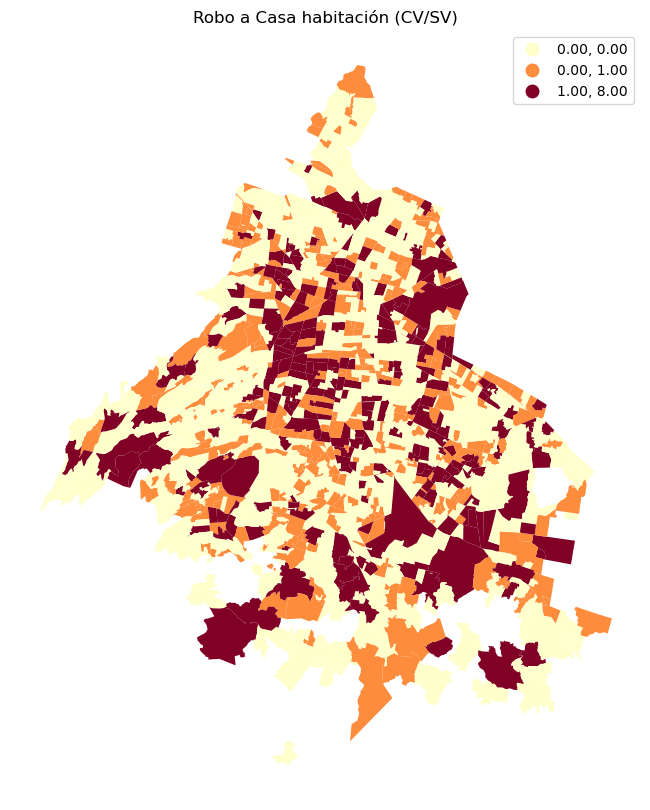

In [63]:
ax = ca.mapa_Y('colonias')

### Mapa de variables independientes

In [64]:
#| export
@patch
def mapa_X(self:CapaDeAnalisis,
           covariable:str, # Nombre de la columna en X para hacer el mapa
           agregacion: str, # colonias/cuadrantes 
           ax:Axes=None, # el eje en donde se hace el mapa  
           size:tuple=(10,10), # tamaño del mapa 
           clasificacion:str='quantiles', # esquema de clasificación demapclassify
           cmap:str='YlOrRd', # mapa de colores de matplotlib
           legend:bool=True # poner o no poner la leyenda
           ):
    """ Regresa un ax con el mapa de la variable dependiente."""
    capa = gpd.read_file("../../datos/criminologia_capas.gpkg", layer=agregacion)
    capa = capa.merge(self.X, on=self.campo_id)
    if ax is None:
        f, ax = plt.subplots(1,figsize=size)
    ax = capa.plot(covariable, scheme=clasificacion, ax=ax, cmap=cmap, legend=legend)
    ax.set_axis_off()
    ax.set_title(covariable)
    return ax

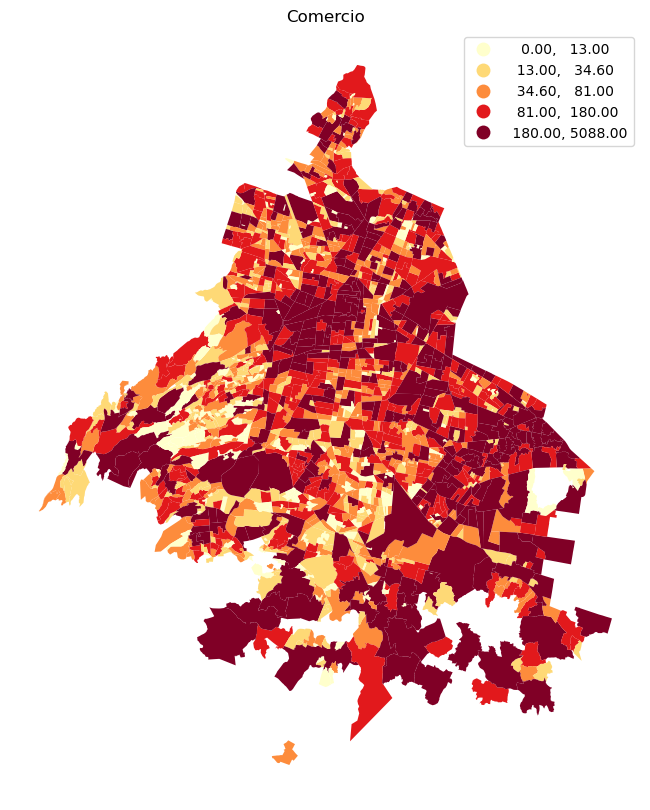

In [65]:
ax = ca.mapa_X('Comercio', 'colonias')

## ModeloGLM

In [ ]:
#| export
class ModeloGLM(object):
    """ Wrapper para modelos de Regresión GLM de statsmodels.
        
        La clase prepara y ajusta un modelo GLM usando la variable objetivo
        definida en CapaDeAnalisis y **todas** las covariables.
        
        Args:
            capa (CapaDeAnalisis): objeto con las variables del modelo.
            familia (statsmodels.api.families.Family()) la distribución a usar en el modelo GLM.
            nombre (str): si no es nulo, el nombre, si no, se asigna nombre al azar.
            
        Atributos:
            capa (CapaDeAnalisis): objeto con las variables del modelo.
            familia (statsmodels.api.families.Family()) la distribución a usar en el modelo GLM.
            formula (str): la fórmula usada para ajustar el modelo.
            df_resultado (DataFrame): los resultados como DataFrame.
            df_diagnostico (DataFrame): los diagnósticos como DataFrame.
            nombre (str): nombre que identifica al modelo.
        Métodos:
            fit(): Ajusta el modelo.
            grafica_de_ajuste(): regresa la gráfica de ajuste.
    """
    def __init__(self, capa, familia, nombre=None):
        self.capa = capa
        self.familia = familia
        self.nombre = self.__get_nombre(nombre)
        self.formula = self.__get_formula()
        self.__modelo = self.__get_modelo()
        self.modelo_ajustado = None
        self.df_resultado = None
        self.df_diagnostico = None
        self.gdf_residuales = None
        self.moran_p_residuales = None
        self.moran_dev_residuales = None

    def __get_nombre(self, nombre):
        if nombre is None:
            letters = string.ascii_lowercase
            return ''.join(random.choice(letters) for i in range(5))
        else:
            return nombre
        
    def __get_formula(self):
        ls = f"Q('{self.capa.Y_nombre}') ~ "
        rs = ""
        for nombre in self.capa.X_nombres:
            rs += f"Q('{nombre}') + "        
        formula = ls + rs
        formula = formula[:-3]
        return formula
    
    def __get_modelo(self):
        modelo = smf.glm(formula = self.formula,
                         data    = self.capa.df, 
                         family  = self.familia)
        return modelo
    
    def __resultados_a_df(self, resultados):
        """LLena self.df_resultado con los resultados del ajuste."""
        results_df = pd.DataFrame({"coef":resultados.params,
                                   "std err": resultados.bse,
                                   "z": resultados.tvalues,
                                   "P>|z|":resultados.pvalues,
                                   "conf_lower":resultados.conf_int()[0],
                                   "conf_higher":resultados.conf_int()[1]
                                    })
        self.df_resultado = results_df

    def __diagnostico_a_df(self, resultados):
        """LLena self.df_diagnostico con los resultados del ajuste."""
        indice = ["Log-Likelihood", "Deviance", "Pearson chi2"]
        valores = [resultados.llf, resultados.deviance, resultados.pearson_chi2]
        results_df = pd.DataFrame({"Diagnóstico": indice, "Valor": valores})
        self.df_diagnostico = results_df
    
    def __residuales_gdf(self, resultados):
        """ Llena el campo gdf_residuales."""
        resid_dev = resultados.resid_deviance.copy()
        resid_dev = stats.zscore(resid_dev)
        resid_df = pd.DataFrame(resid_dev, columns=["Residual Deviance"])  
        resid_p = resultados.resid_pearson
        resid_p = pd.DataFrame(resid_p, columns=["Residual Pearson"])
        resid_df = resid_df.join(resid_p)
        mapa_residuales = self.capa.Y.join(resid_df, how='right')
        geos = (gpd.read_file(DATA_PATH/'criminologia_capas.gpkg',
                             capa=self.capa.agregacion)
                    .set_index(self.capa.campo_id))
        mapa_residuales = geos.merge(mapa_residuales, on=self.capa.campo_id)
        self.gdf_residuales = mapa_residuales
        
    def __calcula_moran_residuales(self):
        moran_dev = Moran(self.gdf_residuales['Residual Deviance'].values, self.capa.w)
        self.moran_dev_residuales = moran_dev
        moran_p = Moran(self.gdf_residuales['Residual Pearson'].values, self.capa.w)
        self.moran_p_residuales = moran_p
        
    def fit(self):
        """ Ajusta el modelo y llena los campos correspondientes.
        
            modelo_ajustado
            df_resultado
            df_diagnostico
            gdf_residuales
            moran_p_residuales
            moran_dev_residuales
        """
        fm = self.__modelo.fit()
        self.modelo_ajustado = fm
        self.__resultados_a_df(fm)
        self.__diagnostico_a_df(fm)
        self.__residuales_gdf(fm)
        self.__calcula_moran_residuales()
        return fm
    
    def grafica_de_ajuste(self, size=(10,5), ax=None):
        """ Regresa un ax con la gráfica de ajuste del modelo.
        
            Args:
            
                size ((int,int)): Tamaño de la figura (opcional default (10,5)) 
                                  si ax !=None, se ignora
                ax (matplotlib.axes): Eje en el que se grafica (opcional, default None)
        """
        if ax is None:
            f, ax = plt.subplots(1,figsize=size)
        y =  self.capa.df[self.capa.Y_nombre].values
        ax = sns.regplot(x=self.modelo_ajustado.mu, y=y, ax=ax)
        ax.set_title('Gráfica de Ajuste del Modelo')
        ax.set_ylabel('Valores observados')
        ax.set_xlabel('Valores ajustados')
        return ax
    
    def grafica_residuales(self, tipo="deviance", size=(10,5), ax=None):
        """ Regresa un ax con la gráfica de Dependencia de los Residuales.
        
            Args:
            
                size ((int,int)): Tamaño de la figura (opcional default (10,5)) 
                                  si ax !=None, se ignora
                ax (matplotlib.axes): Eje en el que se grafica (opcional, default None)       
        """
        observados = self.capa.df[self.capa.Y_nombre].values
        if tipo == "deviance":
            y = self.modelo_ajustado.resid_deviance
            y_label = "Residual (Deviance)"
        else:
            y = self.modelo_ajustado.resid_pearson
            y_label = "Residual (Pearson)"
        if ax is None:
            f, ax = plt.subplots(1,figsize=size)
        ax = sns.scatterplot(x=observados, y=y, ax=ax)
        ax.hlines(0, 0, observados.max(), colors='black')
        ax.set_title('Gráfica de Dependencia de los Residuales')
        ax.set_ylabel(y_label)
        ax.set_xlabel('Valores ajustados')
        return ax   
    
    def histograma_deviance(self, size=(10,5), ax=None):
        """ Regresa un ax con el hitograma de deviance de los residuales.
        
            Args:
            
                size ((int,int)): Tamaño de la figura (opcional default (10,5)) 
                                  si ax !=None, se ignora
                ax (matplotlib.axes): Eje en el que se grafica (opcional, default None)
        """
        resid = self.modelo_ajustado.resid_deviance.copy()
        resid_std = stats.zscore(resid)
        resid_std = pd.DataFrame(resid_std, columns=["Desviación"])
        if ax is None:
            f, ax = plt.subplots(1,figsize=size)
        ax = sns.histplot(data=resid_std, x="Desviación", ax=ax)
        ax.set_title('Histograma de desviación estandarizada')
        ax.set_ylabel('Conteo')
        return ax
    
    def mapa_residuales(self, tipo="deviance", size=(10,10), ax=None,
                        clasificacion='quantiles', 
                        cmap='YlOrRd', legend=True):
        """ Regresa un ax con el mapa de residuales (deviance/pearson)
        
            Args:
            
                agregacion (str): colonias/cuadrantes
                ax (matplotlib.plot.ax): el eje en donde se hace el mapa (opcional, default None)
                size ((int,int)): tamaño del mapa (opcional, si se pasa un eje se ignora)
                clasificacion (str): esquema de clasificación demapclassify (opcional)
                cmap (str): mapa de colores de matplotlib (opcional)
                legend (bool): poner o no poner la leyenda (opcional)
        
        """
        observados = self.capa.df[self.capa.Y_nombre].values
        if tipo == "deviance":
            y = self.modelo_ajustado.resid_deviance
            y_label = "Residual Deviance"
        else:
            y = self.modelo_ajustado.resid_pearson
            y_label = "Residual Pearson"
        if ax is None:
            f, ax = plt.subplots(1,figsize=size)
        ax = self.gdf_residuales.plot(y_label, 
                                      ax=ax, scheme=clasificacion, cmap=cmap, legend=legend)
        ax.set_axis_off()
        ax.set_title("Mapa de residuales")
        return ax
    
    def scatterpĺot_moran(self, tipo="deviance", ax=None):
        """ Regresa un ax con el diagrama de dispersión de Moran para los residuales.
        
            Args:
            
                tipo (str): deviance/pearson el tipo de residuales a graficar, 
                            (opcional, default=deviance) .
                size ((int,int)): Tamaño de la figura (opcional default (10,5)) 
                                  si ax !=None, se ignora
                ax (matplotlib.axes): Eje en el que se grafica (opcional, default None)        
        """
        if tipo == "deviance":
            x_label = "Residual Deviance"
            moran = self.moran_dev_residuales
        elif tipo == "pearson":
            x_label = "Residual Pearson"
            moran = self.moran_p_residuales            
        else:
            raise ValueError("El tipo debe ser 'Residual Deviance' o 'Residual Pearson'")
        if ax is None:
            fig, ax = moran_scatterplot(moran, aspect_equal=True)
            ax.set_ylabel("Retraso espacial")
            ax.set_xlabel(x_label)
            ax.set_title(f"I de Moran {np.round(moran.I, 3)}, Significancia {moran.p_sim}")
        else:
            moran_scatterplot(moran, aspect_equal=True, ax=ax)
            ax.set_ylabel("Retraso espacial")
            ax.set_xlabel(x_label)
            ax.set_title(f"I de Moran {np.round(moran.I, 3)}, Significancia {moran.p_sim}")
        return ax

In [ ]:
m = ModeloGLM(ca, sm.families.NegativeBinomial())
fm = m.fit()
assert type(m.df_resultado) == pd.DataFrame
assert type(m.df_diagnostico) == pd.DataFrame

## ComparaModelos

In [ ]:
#| export
class ComparaModelos(object):
    """ Clase para construir comparaciones de modelos.
        Construte dos DataFrames para visualizar rápidamente una comparación de los modelos:
        uno con los resultados (coeficientes, etc) y otro con los diagnósticos.
        Args:
            modelos (list): Lista de modelos a comparar
            columnas (list): Lista de columnas que aparecen en la comparación de resultados 
                             (opcional, default None)
            redondeo: (int): Decimales a usar en la comparaciónn (opcional, default None)
        Atributos:
            modelos (list): Lista de modelos a comparar
            comparacion (DataFrame): comparación de los resultados
    """
    def __init__(self, modelos, columnas=None, redondeo=None):
        self.modelos = modelos
        self.comparacion = self.__une_resultados(columnas, redondeo)
        self.diagnosticos = self.__une_diagnosticos(redondeo)
    def __une_resultados(self, columnas, redondeo):
        if columnas is None:
            unidos = reduce(lambda left, right: 
                            left.df_resultado.join(right.df_resultado, 
                                                   how='outer', 
                                                   lsuffix="-" + left.nombre,
                                                   rsuffix="-" + right.nombre)
                            ,self.modelos)
        else:
            dfs = [(m.df_resultado, m.nombre) for m in self.modelos]
            dfs = [(df[0][columnas], df[1]) for df in dfs]
            unidos = reduce(lambda left, right: 
                            left[0].join(right[0], 
                                      how='outer', 
                                      lsuffix="-" + left[1],
                                      rsuffix="-" + right[1])
                            ,dfs)
            
        orden = [list(m.df_resultado.index) for m in self.modelos]
        orden = list(set().union(*orden))
        unidos = unidos.reindex(orden)
        if columnas is None:
            valores = self.modelos[0].df_resultado.columns
        else:
            valores = columnas
        nombres = ["Modelo " + m.nombre for m in self.modelos]
        indice_nuevo = pd.MultiIndex.from_product([nombres, valores])
        unidos.columns = indice_nuevo
        if redondeo:
            unidos = unidos.round(redondeo)
        return  unidos
    
    def __une_diagnosticos(self, redondeo):
        unidos = reduce(lambda left, right: 
                        left.df_diagnostico.merge(right.df_diagnostico, 
                                                  on="Diagnóstico",
                                                  suffixes=(" Modelo " + left.nombre, 
                                                            " Modelo " + right.nombre)),
                        self.modelos)
        if redondeo:
            unidos = unidos.round(redondeo)
        return unidos
        
    def graficas_de_ajuste(self, n_cols=2, size=(20,5)):
        """ Gráficas de ajuste para todos los modelos.
        
            Args:
            
                n_cols (int): Número de columnas en la figura
                size ((int, int)): Tamaño de la figura
        """
        n_modelos = len(self.modelos)
        filas = math.ceil(n_modelos / n_cols)
        f, axs = plt.subplots(filas, n_cols, figsize=size)
        f.suptitle('Gráficas de ajuste', fontsize=16)
        axs = axs.ravel()
        for i, ax in enumerate(axs):
            ax = self.modelos[i].grafica_de_ajuste(ax=ax)
            ax.set_title(f"{self.modelos[i].nombre}")
            
    def graficas_residuales(self, tipo='deviance', n_cols=2, size=(20,5)):
        """ Gráficas de residuales para todos los modelos.
        
        
            Args:
             
                tipo (str): pearson/deviance tipo de residuales a graficar.
                n_cols (int): Número de columnas en la figura.
                size ((int, int)): Tamaño de la figura.
        
        """
        n_modelos = len(self.modelos)
        filas = math.ceil(n_modelos / n_cols)
        f, axs = plt.subplots(filas, n_cols, figsize=size)
        f.suptitle('Gráficas de residuales', fontsize=16)        
        axs = axs.ravel()
        for i, ax in enumerate(axs):
            ax = self.modelos[i].grafica_residuales(tipo=tipo, ax=ax)
            ax.set_title(f"{self.modelos[i].nombre}")
            
    def histogramas_deviance(self, n_cols=2, size=(20,5)):
        """ Histogramas de deviance para todos los modelos.
        
            Args:
             
                n_cols (int): Número de columnas en la figura.
                size ((int, int)): Tamaño de la figura.        
        """
        
        n_modelos = len(self.modelos)
        filas = math.ceil(n_modelos / n_cols)
        f, axs = plt.subplots(filas, n_cols, figsize=size)
        f.suptitle('Histogramas de Deviance', fontsize=16)        
        axs = axs.ravel()
        for i, ax in enumerate(axs):
            ax = self.modelos[i].histograma_deviance(ax=ax)
            ax.set_title(f"{self.modelos[i].nombre}")
            
    def mapas_residuales(self, tipo='deviance', n_cols=2, 
                         size=(20,10), clasificacion='quantiles', 
                         cmap='YlOrRd', legend=True):
        """ Mapas de residuales para todos los modelos. 
        
        
            Args:
                
                tipo (str): deviance/pearson el tipo de residual a mapear
                n_cols (int): Número de columnas en la figura.
                size ((int, int)): Tamaño de la figura.
                clasificacion (str): esquema de clasificación (mapclassify).
                cmap (str): mapa de colores (matplotlib).
                legend (bool): desplegar o no la leyenda.
        """
        n_modelos = len(self.modelos)
        filas = math.ceil(n_modelos / n_cols)
        f, axs = plt.subplots(filas, n_cols, figsize=size)
        f.suptitle(f'Mapas de residuales de {tipo}', fontsize=16)        
        axs = axs.ravel()
        for i, ax in enumerate(axs):
            # TODO:size
            ax = self.modelos[i].mapa_residuales(tipo=tipo, ax=ax, 
                                                 clasificacion=clasificacion, 
                                                 cmap=cmap, legend=legend)
            ax.set_title(f"{self.modelos[i].nombre}")
            
    def scatterpĺots_moran(self, tipo="deviance", n_cols=2, size=(20,10)):
        """ Graficas de moran para todos los modelos.
        
        
            Args:
                
                tipo (str): deviance/pearson el tipo de residual a mapear
                n_cols (int): Número de columnas en la figura.
                size ((int, int)): Tamaño de la figura.
        """
        
        n_modelos = len(self.modelos)
        filas = math.ceil(n_modelos / n_cols)
        f, axs = plt.subplots(filas, n_cols, figsize=size)
        if tipo == "deviance":
            titulo = 'Residuales de Deviance'
        else:
            titulo = 'Residuales de Pearson'
        f.suptitle(titulo, fontsize=16)        
        axs = axs.ravel()
        for i, ax in enumerate(axs):
            ax = self.modelos[i].scatterpĺot_moran(tipo="deviance", ax=ax)
            if tipo == "deviance":
                moran = self.modelos[i].moran_dev_residuales
            else:
                moran = self.modelos[i].moran_p_residuales
            
            ax.set_title(f"Modelo {self.modelos[i].nombre}: I de Moran {np.round(moran.I, 3)}, Significancia {moran.p_sim}")
        plt.tight_layout()

In [ ]:
# variables para el segundo modelo
diccionario = get_diccionario_censo()
censo = get_variables_censo()
agregado = agrega_en_unidades(censo, diccionario)
agregado = censo_a_tasas(agregado, diccionario)
vars_viv = agregado[['VIVPAR_HAB', 'VPH_3YMASC']]
vars_indice = ['P5_HLI', 'POB_AFRO', 'PCON_DISC', 'P3A5_NOA', 
               'P6A11_NOA', 'P12A14NOA', 'P15YM_AN', 'PSINDER', 'PDESOCUP']
indice = IndicePCA(agregado, vars_indice)
indice.calcula_indice()
var_m1 = (vars_viv
          .join(indice.indice.set_index('colonia_cve'))
          .rename({'Índice': 'Concentración de Desventajas'}, axis=1))
usos = get_uso_de_suelo()
usos = agrega_uso_suelo(usos, unidades='colonias')
var_m2 = var_m1.join(usos)
# Dos capas de análisis
ca1 = CapaDeAnalisis(Y, var_m1, 'colonias')
ca2 = CapaDeAnalisis(Y, var_m2, 'colonias')
# Ajustamos modelos
m1 = ModeloGLM(ca1, sm.families.NegativeBinomial(),"nulo")
r1 = m1.fit()
m2 = ModeloGLM(ca2, sm.families.NegativeBinomial(), "uso de suelo")
r2 = m2.fit()
# Probamos la comparacion
compara = ComparaModelos([m1,m2])
assert type(compara.comparacion) == pd.DataFrame
assert type(compara.diagnosticos) == pd.DataFrame
compara = ComparaModelos([m1, m2], ['coef', 'P>|z|'], 3)
assert type(compara.comparacion) == pd.DataFrame
assert type(compara.diagnosticos) == pd.DataFrame

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()